In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.modeling import models, fitting, custom_model

from elcoll_utils import colnames, keys, titles, ylabels, elcoll_read, elcoll_plot, elcoll_model, elcoll_results

<IPython.core.display.Javascript object>


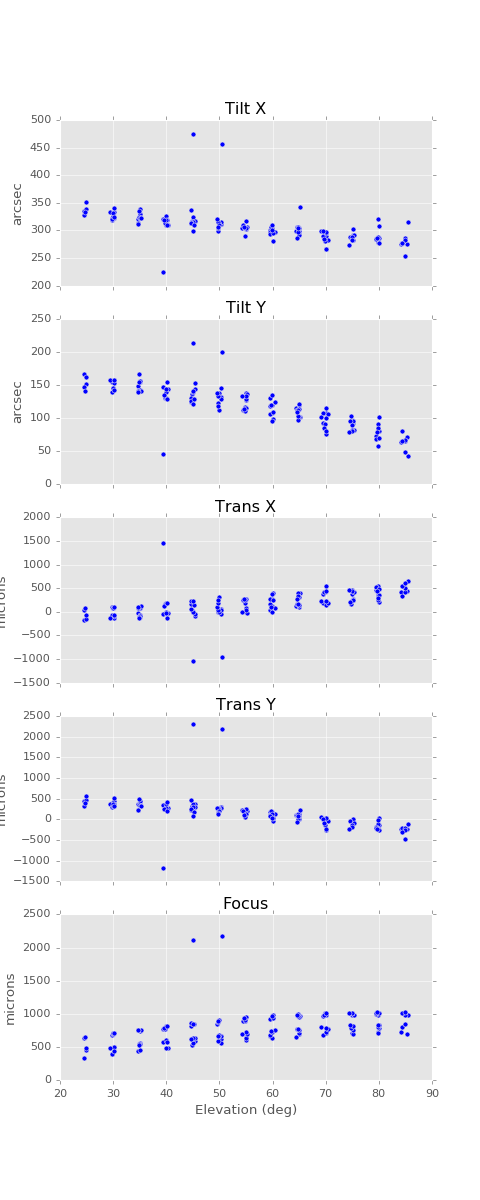

In [2]:
# only one data file for this night, though data was taken at multiple different times...
tot = elcoll_read("ELCOLL.20170109")

elcoll_plot(tot)

We have some spurious data points so we can ``show_in_notebook`` to explore the data and remove them.  It turns out that the bad points are at index values 72, 73, and 74. 

In [ ]:
tot.show_in_notebook()

<IPython.core.display.Javascript object>


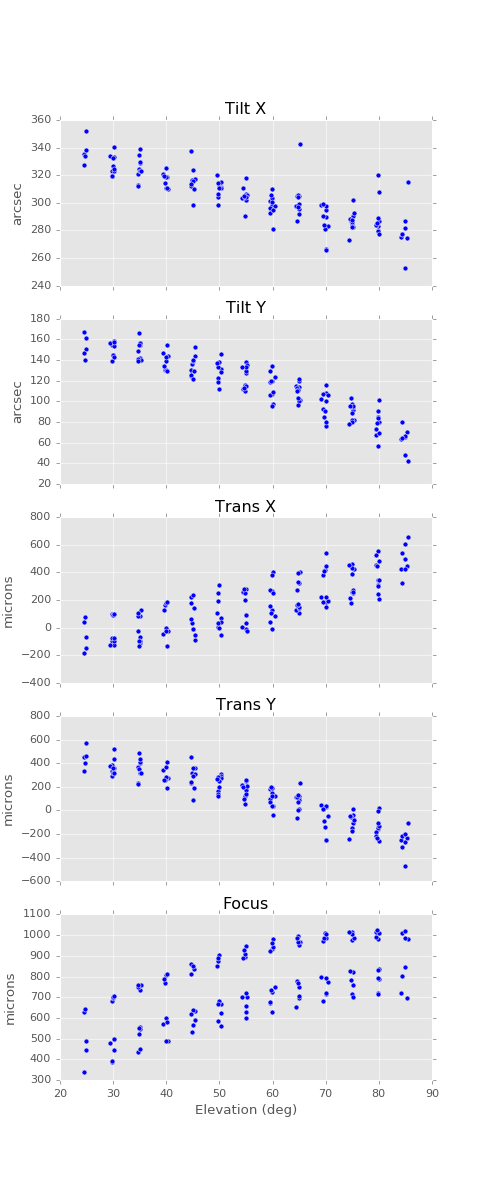

In [3]:
# make a new table and then trim the bad rows out
trim = tot.copy()
trim.remove_rows([72, 73, 74])
elcoll_plot(trim)

In [4]:
fitter = fitting.LevMarLSQFitter()
elcoll = elcoll_model()
mods = {}

In [5]:
for k in keys:
    mods[k] = fitter(elcoll, x=trim['el'], y=trim['oss'], z=trim[k])

In [6]:
elcoll_results(mods)

Tilt X: -49.78*sin(el) +29.10*cos(el) -0.26*T_oss +331.76
Tilt Y: +31.34*sin(el) +130.56*cos(el) +6.46*T_oss -50.27
Trans X: -86.66*sin(el) -717.65*cos(el) -74.96*T_oss +1471.68
Trans Y: +138.06*sin(el) +907.18*cos(el) +32.40*T_oss -830.67
Focus: +800.06*sin(el) +30.21*cos(el) -113.29*T_oss +1385.54


In [ ]:
#plt.scatter(tot['el'], tot['focus'])
plt.scatter(trim['oss'], trim['focus'] - mods['focus'](trim['el'], trim['oss']))
plt.show()